In [26]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

## Load the Dataset

In [27]:
# Load dataset
df = pd.read_csv("UsArrests.csv")
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [28]:
# Explore basic info including data types and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


All datatypes are numeric except for City names. We will drop/index this column later in the analysis, when needed.

Variables are measured in different scales (e.g., Assault counts vs. UrbanPop percentages)
We need to standardize before PCA and clustering.

## Explore the data
Before we proceed with PCA analysis let us get the dataset ready by exploring and cleaning it.

In [29]:
# Get statistical summary
df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


In [30]:
# Check for missing values
df.isnull().sum()

City        0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

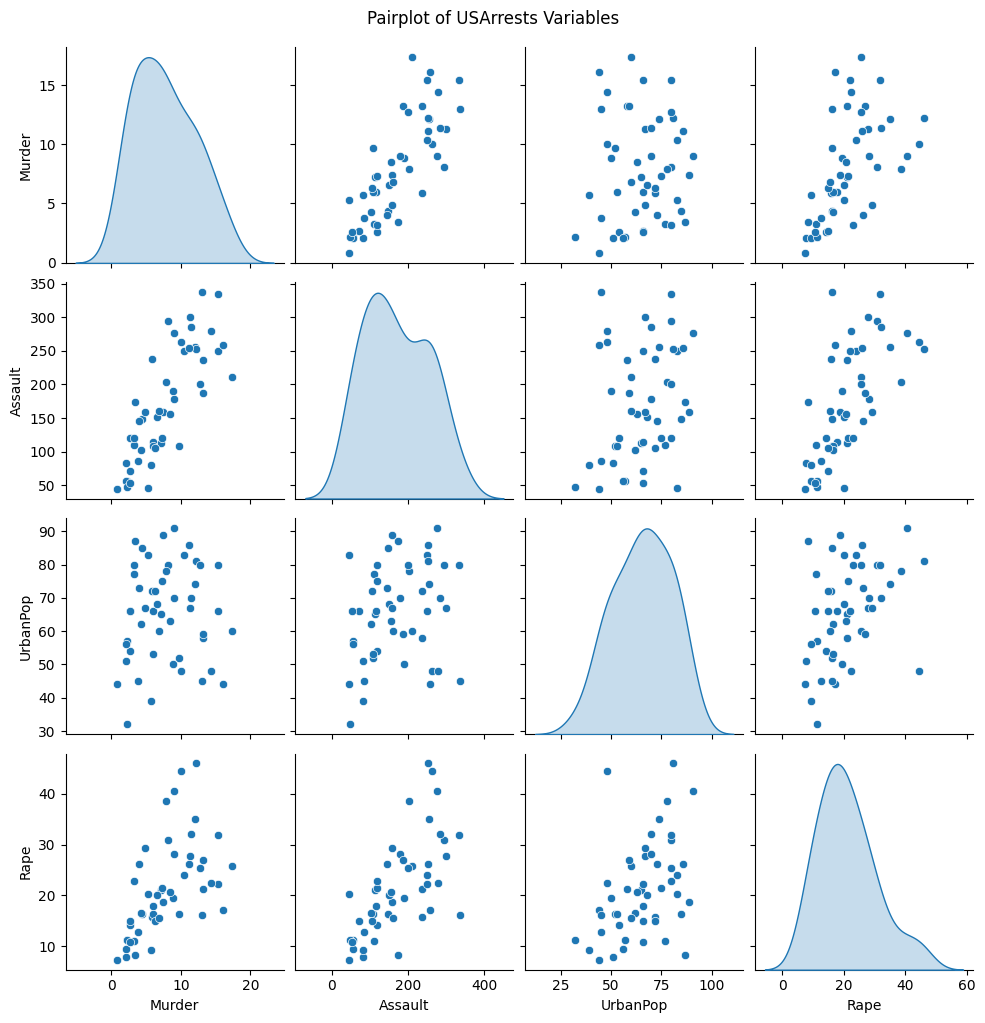

In [31]:
# Pairplot to explore variable relationships
sns.pairplot(df, diag_kind='kde')
plt.suptitle("Pairplot of USArrests Variables", y=1.02)
plt.show()

Pairplot demonstrates strong positive correlations between murder, assault and rape, and weaker positive correlation with urban population(%).

These positive correlations indicate multicollinearity among variables, which makes PCA an appropriate technique for dimensionality reduction.

## Scaling 

As mentioned above, variables are measured in different scales (e.g. Assault counts vs. UrbanPop percentages)
We need to standardize before PCA and clustering.

In [32]:
# First set City column as index
if 'City' in df.columns:
    df.set_index('City', inplace=True)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Create a scaled DataFrame for clarity
scaled_df = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)
scaled_df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,1.255179,0.790787,-0.526195,-0.003451
Alaska,0.513019,1.118060,-1.224067,2.509424
Arizona,0.072361,1.493817,1.009122,1.053466
Arkansas,0.234708,0.233212,-1.084492,-0.186794
California,0.281093,1.275635,1.776781,2.088814


## Correlation Analysis

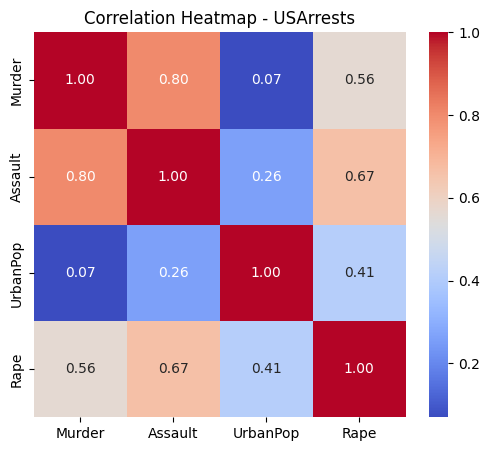

In [33]:

plt.figure(figsize=(6, 5))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap - USArrests")
plt.show()

Numeric correlation heatmap demonstrates strong positive correlation between Assualt and Murder, as well as between Assualt and Rape, with a weaker positive correlation bewtween Rape and Murder.

The correlation with Urbal Population is still positive but much weaker - from 41% corr with Rape to 26% with Assault and 7% with Murder cases.

As mentioned above, strong positive correlations makes PCA an appropriate technique for dimensionality reduction.

## PCA Analysis

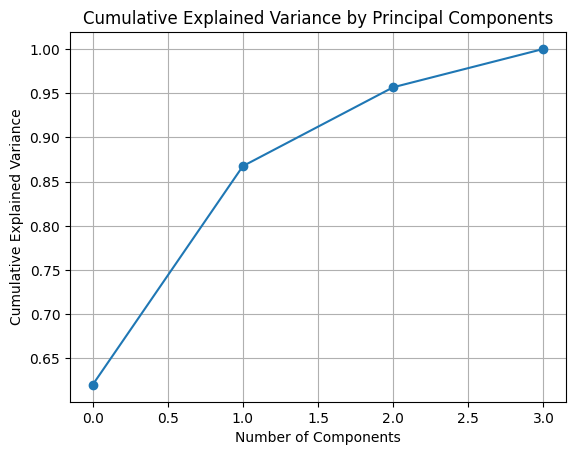

In [34]:
pca = PCA()
pca_data = pca.fit_transform(scaled_data)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Scree plot
plt.plot(np.cumsum(explained_variance), marker='o')
plt.title("Cumulative Explained Variance by Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

The Scree plot demonstrates that 2 principal components cumulatively explain 95% of data variance.

In [35]:
# Lets look at variance explained by each component
for i, ratio in enumerate(explained_variance, 1):
    print(f"PC{i}: {ratio:.2%} variance explained")

PC1: 62.01% variance explained
PC2: 24.74% variance explained
PC3: 8.91% variance explained
PC4: 4.34% variance explained


The first two PCs explain most of variance: 86.75% 

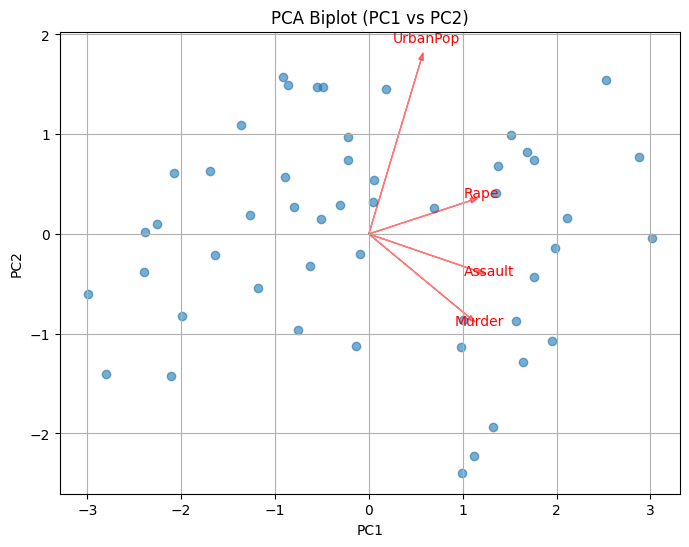

In [ ]:
# Lets look at the biplot of the firast two principal components
def biplot(score, coeff, labels=None):
    """
    Draws a PCA biplot with observation labels (e.g. states) and variable loadings.

    Parameters:
    - score: PCA-transformed data (from pca.fit_transform)
    - coeff: PCA component loadings (pca.components_.T)
    - labels: names of observations (e.g. state names,not critical for our task)
    """
    xs = score[:, 0]
    ys = score[:, 1]
    plt.figure(figsize=(8, 6))
    plt.scatter(xs, ys, alpha=0.6)
    for i, var in enumerate(df.columns):
        plt.arrow(0, 0, coeff[i, 0]*2, coeff[i, 1]*2,
                  color='r', alpha=0.5, head_width=0.05)
        plt.text(coeff[i, 0]*2.2, coeff[i, 1]*2.2, var, color='r', ha='center')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA Biplot (PC1 vs PC2)")
    plt.grid()
    plt.show()

biplot(pca_data, pca.components_.T)


Scatterpoints represent states and points close together - states with similar crime profiles (not critical for our analysis).

Red arrows show how variables contribute to the first two PCs: Murder and Assault drive PC1, indicating that PC1 mainly represents overall violent crime intensity.

UrbanPop drives PC2 more strongly, which appears to capture variation in urbanization levels among states.

## Number of principal components 

Based on the scree plot and biplot we can justify using first 2 PCs as they capture the majority of the variance (more than 85%)

In [37]:
pca_2 = PCA(n_components=2)
pca_2_data = pca_2.fit_transform(scaled_data)

# Add PC column to DataFrame for clustering
pca_df = pd.DataFrame(pca_2_data, columns=['PC1', 'PC2'], index=df.index)
pca_df.head()

,PC1,PC2
City,,
Alabama,0.985566,-1.133392
Alaska,1.950138,-1.073213
Arizona,1.763164,0.745957
Arkansas,-0.141420,-1.119797
California,2.523980,1.542934


## Clustering ( KMeans and Hierarchical )

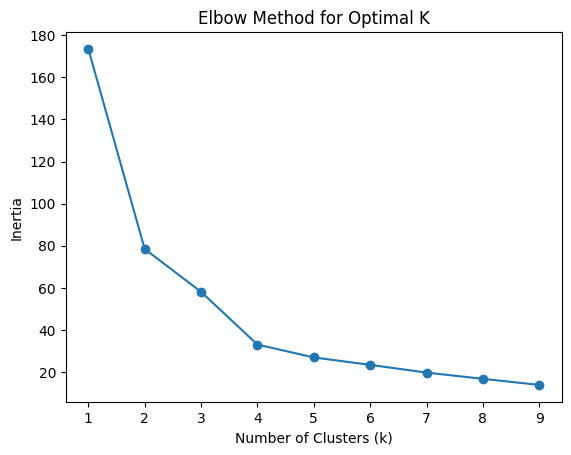

In [38]:
# KMeans clustering

# Determine optimal k using Elbow Method
inertia = []
k_values = range(1, 10)
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(pca_df)
    inertia.append(km.inertia_)

plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

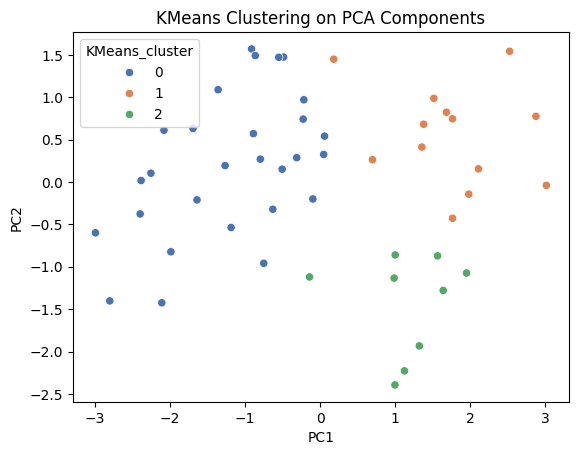

In [39]:
# We choose k=3 based on elbow point
kmeans = KMeans(n_clusters=3, random_state=42)
pca_df['KMeans_cluster'] = kmeans.fit_predict(pca_df)

sns.scatterplot(x="PC1", y="PC2", hue="KMeans_cluster", data=pca_df, palette="deep")
plt.title("KMeans Clustering on PCA Components")
plt.show()

We can see three clusters based on 2 PCs distinguished by KMeans method 

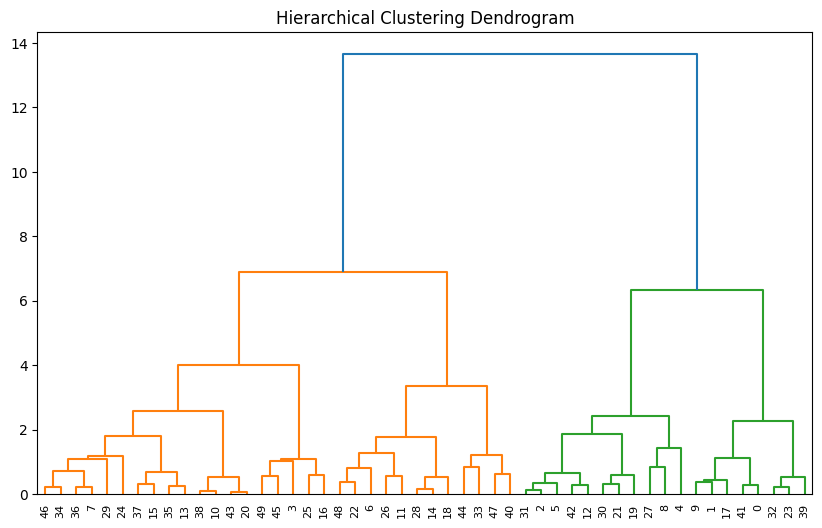

In [40]:
# Clustering - Hierarchical
linked = linkage(pca_df[["PC1", "PC2"]], method='ward')

plt.figure(figsize=(10, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()


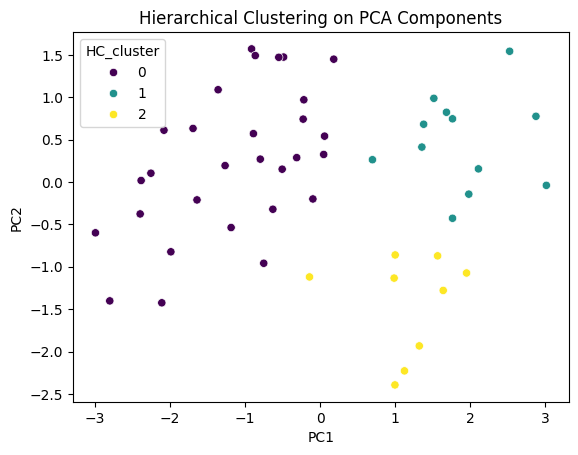

In [41]:
# Fit Hierarchical model (3 clusters)
hc = AgglomerativeClustering(n_clusters=3, linkage='ward')
pca_df['HC_cluster'] = hc.fit_predict(pca_df)

# Let us visalise Hierarchical clustering on PSA components
sns.scatterplot(x="PC1", y="PC2", hue="HC_cluster", data=pca_df, palette="viridis")
plt.title("Hierarchical Clustering on PCA Components")
plt.show()

Hierarchical clustering method has distinguished three clusters based on 2 principal components, very similar to the three clusters identified by KMeans method.

## Cluster analysis

In [42]:
# Combine clustered data with original data for interpretation
clustered_df = pd.concat([df, pca_df], axis=1)
clustered_df.head()

,Murder,Assault,UrbanPop,Rape,PC1,PC2,KMeans_cluster,HC_cluster
City,,,,,,,,
Alabama,13.2,236,58,21.2,0.985566,-1.133392,2,2
Alaska,10.0,263,48,44.5,1.950138,-1.073213,2,2
Arizona,8.1,294,80,31.0,1.763164,0.745957,1,1
Arkansas,8.8,190,50,19.5,-0.141420,-1.119797,2,2
California,9.0,276,91,40.6,2.523980,1.542934,1,1


In [43]:
# Examine mean values per cluster
print("KMeans Cluster Means:")
display(clustered_df.groupby('KMeans_cluster').mean())

print("\nHierarchical  Cluster Means:")
display(clustered_df.groupby('HC_cluster').mean())

KMeans Cluster Means:


,Murder,Assault,UrbanPop,Rape,PC1,PC2,HC_cluster
KMeans_cluster,,,,,,,
0,4.639286,110.142857,63.214286,15.714286,-1.188381,0.202278,0.000000
1,10.615385,249.384615,79.153846,31.215385,1.756612,0.556006,0.923077
2,13.500000,245.777778,53.111111,23.977778,1.159858,-1.432428,2.000000



Hierarchical  Cluster Means:


,Murder,Assault,UrbanPop,Rape,PC1,PC2,KMeans_cluster
HC_cluster,,,,,,,
0,4.734483,111.827586,64.103448,15.820690,-1.141142,0.245286,0.034483
1,10.883333,256.916667,78.333333,32.250000,1.887866,0.481548,1.000000
2,13.500000,245.777778,53.111111,23.977778,1.159858,-1.432428,2.000000


Cluster analysis on the level of crime and urban population in different States

 - Cluster 0 States: Low crime, high urban population.
 - Cluster 1 States: Highest Assault and Rape, and high Murder rates (violent states), the highest urban population.
 - Cluster 2 States: High crime levels (Assault and Rape) and the highest Murder rates, the liest urban population.
 